In [1]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import optim
import torch.nn.functional as F

In [2]:
# 生成两两组合的列表
def generate(N):
    col = []
    col_rev = []
    for i in range(1,N):
        for j in range(0,i):
            col.append([i,j])
            col_rev.append([j,i])
    return col, col_rev

num,num_rev = generate(9)

In [3]:
#inception1:convolution:10,pooling:3
class Inception1(nn.Module):
    
    #该部分主要提供窗口为10的卷积，以及尺寸为3的池化
    #输入为9*30，输出为513*1
    #我们不需要激活函数，因为我们希望我们的特征提取层有和wq101因子类似的构造逻辑
    def __init__(self,num,num_rev):
        super(Inception1,self).__init__()
        self.num = num
        self.num_rev = num_rev
        self.bc1 = nn.BatchNorm2d(1,eps = 1e-5,affine = True)
        self.bc2 = nn.BatchNorm2d(1,eps = 1e-5,affine = True)
        self.bc3 = nn.BatchNorm2d(1,eps = 1e-5,affine = True)
        self.bc4 = nn.BatchNorm2d(1,eps = 1e-5,affine = True)
        self.bc5 = nn.BatchNorm2d(1,eps = 1e-5,affine = True)
        self.bc6 = nn.BatchNorm2d(1,eps = 1e-5,affine = True)
        self.bc7 = nn.BatchNorm2d(1,eps = 1e-5,affine = True)
        self.bc8 = nn.BatchNorm2d(1,eps = 1e-5,affine = True)
        self.bc9 = nn.BatchNorm2d(1,eps = 1e-5,affine = True)
        self.bc10 = nn.BatchNorm2d(1,eps = 1e-5,affine = True)
        self.bc_pool1 = nn.BatchNorm2d(1,eps = 1e-5,affine = True)
        self.bc_pool2 = nn.BatchNorm2d(1,eps = 1e-5,affine = True)
        self.bc_pool3 = nn.BatchNorm2d(1,eps = 1e-5,affine = True)
        self.max_pool = nn.MaxPool2d(kernel_size = (1,3),stride = (1,3))
        self.avg_pool = nn.AvgPool2d(kernel_size = (1,3),stride = (1,3))
        self.min_pool = nn.MaxPool2d(kernel_size = (1,3),stride = (1,3)) #实际上没有最小池化
        
    def forward(self,data1): #B*1*9*30
        
        data1 = data1.detach().numpy()
        num = self.num
        num_rev = self.num_rev
        conv1 = self.ts_cov4d(data1,num,num_rev,10).to(torch.float)
        conv2 = self.ts_max(data1,10).to(torch.float)
        conv3 = self.ts_min(data1,10).to(torch.float)
        conv4 = self.ts_corr4d(data1,num,num_rev,10).to(torch.float)
        conv6 = self.ts_decaylinear(data1,10).to(torch.float)
        conv7 = self.ts_std(data1,10).to(torch.float)
        conv8 = self.ts_mean(data1,10).to(torch.float)
        conv9 = self.ts_zcore(data1,10).to(torch.float)
        conv10 = self.ts_mul(data1,num,num_rev,10).to(torch.float)
        
        batch1 = self.bc1(conv1)
        batch2 = self.bc2(conv2)
        batch3 = self.bc3(conv3)
        batch4 = self.bc4(conv4)
        batch6 = self.bc6(conv6)
        batch7 = self.bc7(conv7)
        batch8 = self.bc8(conv8)
        batch9 = self.bc9(conv9)
        batch10 = self.bc10(conv10)
        feature1 = torch.cat([batch1,batch2,batch3,batch4,batch6,batch7,batch8,batch9,batch10],axis = 2)
        #171*3
        maxpool = self.max_pool(feature1)
        maxpool = self.bc_pool1(maxpool)
        avgpool = self.avg_pool(feature1)
        avgpool = self.bc_pool2(avgpool)
        minpool = -self.min_pool(-1*feature1)
        minpool = self.bc_pool3(minpool)
        
        pool_cat = torch.cat([maxpool,avgpool,minpool],axis = 2)
        pool_cat = pool_cat.flatten(start_dim = 1) #N*513
        
        return pool_cat
        
    def ts_zcore(self,Matrix,stride):
        W = Matrix.shape[3]
        H = Matrix.shape[2]
        new_H = H
        if W % stride == 0:
            Index_list = list(np.arange(0,W+stride,stride))
        else:
            mod = W % stride
            Index_list = list(np.arange(0,W+stride-mod,stride)) + [W]
        l = [] 
        for i in range(len(Index_list)-1):
            start = Index_list[i]
            end = Index_list[i+1]
            data = Matrix[:,:,:,start:end]
            mean = data.mean(axis = 3,keepdims = True)
            std = data.std(axis = 3, keepdims = True)+0.1
            l.append(mean/std)  
        zscore = np.squeeze(np.array(l)).transpose(1,2,0).reshape(-1,1,new_H,len(Index_list)-1)
        return torch.from_numpy(zscore)
    
    def ts_cov4d(self,Matrix,num,num_rev,stride):
        W = Matrix.shape[3]
        H = Matrix.shape[2]
        new_H = len(num)
        if W % stride == 0:
            Index_list = list(np.arange(0,W+stride,stride))
        else:
            mod = W % stride
            Index_list = list(np.arange(0,W+stride-mod,stride)) + [W]
        l = [] #存放长度为num的协方差
        for i in range(len(Index_list)-1):
            start_index = Index_list[i]
            end_index = Index_list[i+1]
            data1 = Matrix[:,:,num,start_index:end_index] #N*C*len(num)*2*step
            data2 = Matrix[:,:,num_rev,start_index:end_index]
            mean1 = data1.mean(axis = 4,keepdims = True)
            mean2 = data2.mean(axis = 4,keepdims = True)
            spread1 = data1 - mean1
            spread2 = data2 - mean2
            cov = ((spread1 * spread2).sum(axis = 4, keepdims = True)/(data1.shape[4]-1)).mean(axis = 3, keepdims = True)
            l.append(cov) #len(num) * N * 2
        cov = np.squeeze(np.array(l)).transpose(1,2,0).reshape(-1,1,new_H,len(Index_list)-1)
        return torch.from_numpy(cov)
    
    def ts_corr4d(self,Matrix,num,num_rev,stride):
        W = Matrix.shape[3]
        H = Matrix.shape[2]
        new_H = len(num)
        if W % stride == 0:
            Index_list = list(np.arange(0,W+stride,stride))
        else:
            mod = W % stride
            Index_list = list(np.arange(0,W+stride-mod,stride)) + [W]
        l = [] #存放长度为num的相关系数
        for i in range(len(Index_list)-1):
            start = Index_list[i]
            end = Index_list[i+1]
            data1 = Matrix[:,:,num,start:end]
            data2 = Matrix[:,:,num_rev,start:end]
            std1 = data1.std(axis = 4,keepdims = True)
            std2 = data2.std(axis = 4,keepdims = True)
            std = (std1*std2).mean(axis = 3,keepdims = True)
            l.append(std)
        std = np.squeeze(np.array(l)).transpose(1,2,0).reshape(-1,1,new_H,len(Index_list)-1)+0.1
        cov = self.ts_cov4d(Matrix,num,num_rev,stride)
        corr = cov/std
        return corr

    def ts_max(self,Matrix,stride):
        W = Matrix.shape[3]
        H = Matrix.shape[2]
        new_H = H
        if W % stride == 0:
            Index_list = list(np.arange(0,W+stride,stride))
        else:
            mod = W % stride
            Index_list = list(np.arange(0,W+stride-mod,stride)) + [W]
        l = []
        for i in range(len(Index_list)-1):
            start_index = Index_list[i]
            end_index = Index_list[i+1]
            data1 = Matrix[:,:,:,start_index:end_index] 
            max_ = data1.min(axis = 3)
            l.append(max_)
        ts_max = np.squeeze(np.array(l)).transpose(1,2,0).reshape(-1,1,new_H,len(Index_list)-1)
    
        return torch.from_numpy(ts_max)
    
    def ts_min(self,Matrix,stride):
        W = Matrix.shape[3]
        H = Matrix.shape[2]
        new_H = H
        if W % stride == 0:
            Index_list = list(np.arange(0,W+stride,stride))
        else:
            mod = W % stride
            Index_list = list(np.arange(0,W+stride-mod,stride)) + [W]
        l = []
        for i in range(len(Index_list)-1):
            start_index = Index_list[i]
            end_index = Index_list[i+1]
            data1 = Matrix[:,:,:,start_index:end_index] 
            min_ = data1.min(axis = 3)
            l.append(min_)
        ts_min = np.squeeze(np.array(l)).transpose(1,2,0).reshape(-1,1,new_H,len(Index_list)-1)
    
        return torch.from_numpy(ts_min)

    def ts_return(self,Matrix,stride):
        W = Matrix.shape[3]
        H = Matrix.shape[2]
        new_H = H
        if W % stride == 0:
            Index_list = list(np.arange(0,W+stride,stride))
        else:
            mod = W % stride
            Index_list = list(np.arange(0,W+stride-mod,stride)) + [W]
        l = []
        for i in range(len(Index_list)-1):
            start_index = Index_list[i]
            end_index = Index_list[i+1]
            data1 = Matrix[:,:,:,start_index:end_index]
            return_ = data1[:,:,:,-1]/(data1[:,:,:,0]+0.1)-1
            l.append(return_)
        ts_return = np.squeeze(np.array(l)).transpose(1,2,0).reshape(-1,1,new_H,len(Index_list)-1)

        return torch.from_numpy(ts_return)

    def ts_decaylinear(self,Matrix,stride):
        W = Matrix.shape[3]
        H = Matrix.shape[2]
        new_H = H
        if W % stride == 0:
            Index_list = list(np.arange(0,W+stride,stride))
        else:
            mod = W % stride
            Index_list = list(np.arange(0,W+stride-mod,stride)) + [W]
        l = []
        for i in range(len(Index_list)-1):
            start = Index_list[i]
            end = Index_list[i+1]
            range_ = end-start
            weight = np.arange(1,range_+1)
            weight = weight/weight.sum()#权重向量
            data = Matrix[:,:,:,start:end]
            wd = (data*weight).sum(axis = 3, keepdims = True)
            l.append(wd)
        
        weight_decay = np.squeeze(np.array(l)).transpose(1,2,0).reshape(-1,1,new_H,len(Index_list)-1)
        return torch.from_numpy(weight_decay)

    def ts_std(self,Matrix,stride):
        W = Matrix.shape[3]
        H = Matrix.shape[2]
        new_H = H
        if W % stride == 0:
            Index_list = list(np.arange(0,W+stride,stride))
        else:
            mod = W % stride
            Index_list = list(np.arange(0,W+stride-mod,stride)) + [W]
        l = []
        for i in range(len(Index_list)-1):
            start = Index_list[i]
            end = Index_list[i+1]
            data = Matrix[:,:,:,start:end]
            std = data.std(axis = 3, keepdims = True)
            l.append(std)
        std4d = np.squeeze(np.array(l)).transpose(1,2,0).reshape(-1,1,new_H,len(Index_list)-1)
        return torch.from_numpy(std4d)

    def ts_mean(self,Matrix,stride):
        W = Matrix.shape[3]
        H = Matrix.shape[2]
        new_H = H
        if W % stride == 0:
            Index_list = list(np.arange(0,W+stride,stride))
        else:
            mod = W % stride
            Index_list = list(np.arange(0,W+stride-mod,stride)) + [W]
        l = []
        for i in range(len(Index_list)-1):
            start = Index_list[i]
            end = Index_list[i+1]
            data = Matrix[:,:,:,start:end]
            mean = data.mean(axis = 3, keepdims = True)
            l.append(mean)
        mean4d = np.squeeze(np.array(l)).reshape(-1,1,new_H,len(Index_list)-1)
        return torch.from_numpy(mean4d)

    def ts_mul(self,Matrix,num,num_rev,stride):
        W = Matrix.shape[3]
        H = Matrix.shape[2]
        new_H = len(num)
        if W % stride == 0:
            Index_list = list(np.arange(0,W+stride,stride))
        else:
            mod = W % stride
            Index_list = list(np.arange(0,W+stride-mod,stride)) + [W]
        l = []
        #思路来源：换手率*收益率序列的均值
        for i in range(len(Index_list)-1):
            start = Index_list[i]
            end = Index_list[i+1]
            data1 = Matrix[:,:,num,start:end]
            data2 = Matrix[:,:,num_rev,start:end]
            mul = (data1*data2).mean(axis = 4,keepdims = True).mean(axis = 3,keepdims = True)
            l.append(mul)
        multi = np.squeeze(np.array(l)).transpose(1,2,0).reshape(-1,1,new_H,len(Index_list)-1)
    
        return torch.from_numpy(multi)

In [4]:
#inception2:convolution:3,pooling:10
class Inception2(Inception1):
    
    #该部分主要提供窗口为3的卷积，以及尺寸为10的池化
    #输入为9*30，输出为513*1
    #我们不需要激活函数，因为我们希望我们的特征提取层有和wq101因子类似的构造逻辑
    def __init__(self,num,num_rev):
        super().__init__(num, num_rev)
        self.num = num
        self.num_rev = num_rev
        self.bc1 = nn.BatchNorm2d(1,eps = 1e-5,affine = True)
        self.bc2 = nn.BatchNorm2d(1,eps = 1e-5,affine = True)
        self.bc3 = nn.BatchNorm2d(1,eps = 1e-5,affine = True)
        self.bc_pool1 = nn.BatchNorm2d(1,eps = 1e-5,affine = True)
        self.bc_pool2 = nn.BatchNorm2d(1,eps = 1e-5,affine = True)
        self.bc_pool3 = nn.BatchNorm2d(1,eps = 1e-5,affine = True)
        self.bc_pool4 = nn.BatchNorm2d(1,eps = 1e-5,affine = True)
        self.bc_pool5 = nn.BatchNorm2d(1,eps = 1e-5,affine = True)
        self.bc_pool6 = nn.BatchNorm2d(1,eps = 1e-5,affine = True)
        self.bc_pool7 = nn.BatchNorm2d(1,eps = 1e-5,affine = True)
        self.bc_pool8 = nn.BatchNorm2d(1,eps = 1e-5,affine = True)
        self.bc_pool9 = nn.BatchNorm2d(1,eps = 1e-5,affine = True)
        self.bc_pool10 = nn.BatchNorm2d(1,eps = 1e-5,affine = True)
        self.max_pool = nn.MaxPool2d(kernel_size = (1,3),stride = (1,3))
        self.avg_pool = nn.AvgPool2d(kernel_size = (1,3),stride = (1,3))
        self.min_pool = nn.MaxPool2d(kernel_size = (1,3),stride = (1,3)) #实际上没有最小池化
        
    def forward(self,data2): #B*1*9*30
        
        data2 = data2.detach().numpy()
        num = self.num
        num_rev = self.num_rev
        conv1 = self.ts_cov4d(data2,num,num_rev,10).to(torch.float)
        conv2 = self.ts_max(data2,10).to(torch.float)
        conv3 = self.ts_min(data2,10).to(torch.float)
        conv4 = self.ts_corr4d(data2,num,num_rev,10).to(torch.float)
        conv6 = self.ts_decaylinear(data2,10).to(torch.float)
        conv7 = self.ts_std(data2,10).to(torch.float)
        conv8 = self.ts_mean(data2,10).to(torch.float)
        conv9 = self.ts_zcore(data2,10).to(torch.float)
        conv10 = self.ts_mul(data2,num,num_rev,10).to(torch.float)
        
        batch1 = self.bc1(conv1)
        batch2 = self.bc2(conv2)
        batch3 = self.bc3(conv3)
        batch4 = self.bc4(conv4)
        batch6 = self.bc6(conv6)
        batch7 = self.bc7(conv7)
        batch8 = self.bc8(conv8)
        batch9 = self.bc9(conv9)
        batch10 = self.bc10(conv10)
        feature1 = torch.cat([batch1,batch2,batch3,batch4,batch6,batch7,batch8,batch9,batch10],axis = 2)
        #171*3
        maxpool = self.max_pool(feature1)
        maxpool = self.bc_pool1(maxpool)
        avgpool = self.avg_pool(feature1)
        avgpool = self.bc_pool2(avgpool)
        minpool = -self.min_pool(-1*feature1)
        minpool = self.bc_pool3(minpool)
        
        pool_cat = torch.cat([maxpool,avgpool,minpool],axis = 2)
        pool_cat = pool_cat.flatten(start_dim = 1) #N*513
        
        return pool_cat

In [5]:
#对原始的输入时序做两层的GRU编码，再残差连接到最后
class Embedding(nn.Module):
    def __init__(self):
        super(Embedding,self).__init__()
        self.gru = nn.GRU(9,30,2)#两层的GRU
        self.bidirectional = False #no Bi-GRU
        
    def forward(self,data):
        data = data.squeeze(1).transpose(1,0).transpose(2,0) #N*1*9*30 -> 30*100*9
        output, hn = self.gru(data)
        h = hn[-(1 + int(self.bidirectional)):]
        x = torch.cat(h.split(1), dim=-1).squeeze(0)
        return x #N*30,每个股票编码成长度为30的向量

In [6]:
class AlphaNet(nn.Module):
    
    def __init__(self,fc1_num,fc2_num,num,num_rev,dropout_rate):
        super(AlphaNet,self).__init__()
        self.num = num
        self.num_rev = num_rev
        self.fc1_num = fc1_num
        self.fc2_num = fc2_num
        #parallel inception
        self.Inception_1 = Inception1(num,num_rev)
        self.Inception_2 = Inception2(num,num_rev)
        #GRU embedding
        self.Embedding = Embedding()
        #two fully connected layer
        self.fc1 = nn.Linear(fc1_num,fc2_num)
        self.fc2 = nn.Linear(fc2_num,1)
        #activation function
        self.relu = nn.ReLU()
        #drop out layer
        self.dropout = nn.Dropout(dropout_rate)
        self._init_weights()
        
    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)#全连接层weights初始化，xavier的均匀分布初始化
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc1.bias, std=1e-6)#bias初始化
        nn.init.normal_(self.fc2.bias, std=1e-6)
        
    def forward(self,data):
        data_1 = self.Inception_1(data) #N*513
        data_2 = self.Inception_2(data) #N*513
        data_3 = self.Embedding(data) #N*30
        pool_cat = torch.cat([data_1,data_2,data_3],axis = 1) #N*1056
        x = self.fc1(pool_cat)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = x.to(torch.float)
        
        return x

In [7]:
X_train = np.load('../data/X_train.npy')
y_train = np.load('../data/y_train.npy')
X_test = np.load('../data/X_test.npy')
y_test = np.load('../data/y_test.npy')
print("Training samples: ", X_train.shape[0])
print("Testing samples: ", X_test.shape[0])

Training samples:  11825
Testing samples:  4943


In [8]:
trainx = torch.from_numpy(np.array(X_train)).reshape(len(X_train),1,9,30)#transform to tensor
trainy = torch.from_numpy(np.array(y_train)).reshape(len(y_train),1) #label for regression
testx = torch.from_numpy(np.array(X_test)).reshape(len(X_test),1,9,30)
testy = torch.from_numpy(np.array(y_test)).reshape(len(y_test),1)
batch_size = 1000 
class Factor_data(Dataset):
    
    def __init__(self, train_x, train_y): #默认输入的时候就已经是tensor
        self.len = len(train_x)
        self.x_data = train_x
        self.y_data = train_y
    
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len
#put into data loader
train_data = Factor_data(trainx, trainy) 
train_loader = DataLoader(dataset = train_data,
                         batch_size = batch_size,
                         shuffle = False) #不打乱数据集
test_data = Factor_data(testx, testy)
test_loader = DataLoader(dataset = test_data,
                        batch_size= batch_size,
                        shuffle = False) #不打乱数据集


In [9]:

#Building the model
alphanet = AlphaNet(1002,30,num,num_rev,0.5)


In [10]:
#weight decay: 对所有weight参数进行L2正则化
weight_list,bias_list = [],[]
for name,p in alphanet.named_parameters():
    if 'bias' in name:
        bias_list += [p]
    else:
        weight_list += [p]
optimizer = optim.SGD([{'params': weight_list, 'weight_decay':1e-5},
                       {'params': bias_list, 'weight_decay':0}],
                      lr = 1e-3,
                      momentum = 0.9)
criterion = nn.MSELoss()
#training
epoch_num = 1
loss_list = []
test_loss = []
for epoch in range(epoch_num ):
    for data,label in train_loader:
        #训练模式
        alphanet.train()#training pattern, grad required.
        out_put = alphanet(data.to(torch.float))
        loss = criterion(out_put,label.to(torch.float))
        loss_list.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() #renew the parameters
        
        #测试模式
        alphanet.eval()
        y_pred = alphanet(testx.to(torch.float))
        testloss = criterion(y_pred,testy)
        test_loss.append(testloss.item())
        #print("ok")
    
    #print("current epoch time:",epoch+1)
    #print("current loss of epoch ",epoch+1,":", train_loss.item())


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


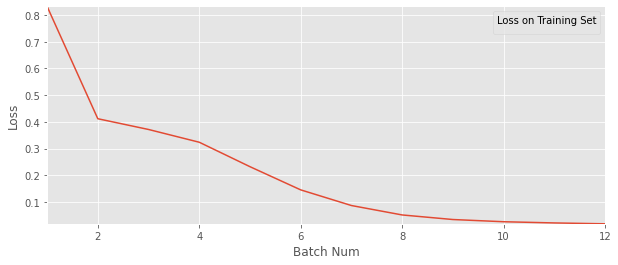

In [11]:
#Visualization
with plt.style.context(['ggplot']):
    fig, ax = plt.subplots(figsize = (10,4)) #指定画布大小
    x = list(np.arange(1,len(test_loss)+1))
    y = test_loss 
    ax.plot(x,y)
    ax.legend(title = "Loss on Training Set")
    ax.autoscale(tight = True)
    ax.set(xlabel = 'Batch Num') #label使用latex语法
    ax.set(ylabel = 'Loss')